<a href="https://colab.research.google.com/github/yamaoka-m/first/blob/master/JoJoGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# JoJoGAN: ワンショット顔スタイル変換

In [9]:
#@title セットアップ
!git clone https://github.com/cedro3/JoJoGAN.git
%cd JoJoGAN
!pip install tqdm gdown scikit-learn==0.22 scipy lpips dlib opencv-python wandb
!wget https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
!sudo unzip ninja-linux.zip -d /usr/local/bin/
!sudo update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force

%load_ext autoreload
%autoreload 2

import torch
torch.backends.cudnn.benchmark = True
from torchvision import transforms, utils
from util import *
from PIL import Image
import math
import random
import os

import numpy as np
from torch import nn, autograd, optim
from torch.nn import functional as F
from tqdm import tqdm
import lpips
import wandb
from model import *
from e4e_projection import projection as e4e_projection

from google.colab import files
from copy import deepcopy
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

os.makedirs('inversion_codes', exist_ok=True)
os.makedirs('style_images', exist_ok=True)
os.makedirs('style_images_aligned', exist_ok=True)
os.makedirs('models', exist_ok=True)



# Download models
#markdown You may optionally enable downloads with pydrive in order to authenticate and avoid drive download limits.
download_with_pydrive = False #param {type:"boolean"}
#device = 'cuda' #param ['cuda', 'cpu']
# Check if cuda is available, otherwise use cpu
device = 'cuda' if torch.cuda.is_available() else 'cpu' #param ['cuda', 'cpu']


!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2
!mv shape_predictor_68_face_landmarks.dat models/dlibshape_predictor_68_face_landmarks.dat
%matplotlib inline


drive_ids = {
    "stylegan2-ffhq-config-f.pt": "1Yr7KuD959btpmcKGAUsbAk5rPjX2MytK",
    "e4e_ffhq_encode.pt": "1o6ijA3PkcewZvwJJ73dJ0fxhndn0nnh7",
    "restyle_psp_ffhq_encode.pt": "1nbxCIVw9H3YnQsoIPykNEFwWJnHVHlVd",
    "arcane_caitlyn.pt": "1gOsDTiTPcENiFOrhmkkxJcTURykW1dRc",
    "arcane_caitlyn_preserve_color.pt": "1cUTyjU-q98P75a8THCaO545RTwpVV-aH",
    "arcane_jinx_preserve_color.pt": "1jElwHxaYPod5Itdy18izJk49K1nl4ney",
    "arcane_jinx.pt": "1quQ8vPjYpUiXM4k1_KIwP4EccOefPpG_",
    "arcane_multi_preserve_color.pt": "1enJgrC08NpWpx2XGBmLt1laimjpGCyfl",
    "arcane_multi.pt": "15V9s09sgaw-zhKp116VHigf5FowAy43f",
    "sketch_multi.pt": "1GdaeHGBGjBAFsWipTL0y-ssUiAqk8AxD",
    "disney.pt": "1zbE2upakFUAx8ximYnLofFwfT8MilqJA",
    "disney_preserve_color.pt": "1Bnh02DjfvN_Wm8c4JdOiNV4q9J7Z_tsi",
    "jojo.pt": "13cR2xjIBj8Ga5jMO7gtxzIJj2PDsBYK4",
    "jojo_preserve_color.pt": "1ZRwYLRytCEKi__eT2Zxv1IlV6BGVQ_K2",
    "jojo_yasuho.pt": "1grZT3Gz1DLzFoJchAmoj3LoM9ew9ROX_",
    "jojo_yasuho_preserve_color.pt": "1SKBu1h0iRNyeKBnya_3BBmLr4pkPeg_L",
    "supergirl.pt": "1L0y9IYgzLNzB-33xTpXpecsKU-t9DpVC",
    "supergirl_preserve_color.pt": "1VmKGuvThWHym7YuayXxjv0fSn32lfDpE",
    "art.pt": "1a0QDEHwXQ6hE_FcYEyNMuv5r5UnRQLKT",
}

# gdownアップデート
! pip install --upgrade gdown

# from StyelGAN-NADA
class Downloader(object):
    def __init__(self, use_pydrive):
        self.use_pydrive = use_pydrive

        if self.use_pydrive:
            self.authenticate()

    def authenticate(self):
        auth.authenticate_user()
        gauth = GoogleAuth()
        gauth.credentials = GoogleCredentials.get_application_default()
        self.drive = GoogleDrive(gauth)

    def download_file(self, file_name):
        file_dst = os.path.join('models', file_name)
        file_id = drive_ids[file_name]
        if not os.path.exists(file_dst):
            print(f'Downloading {file_name}')
            if self.use_pydrive:
                downloaded = self.drive.CreateFile({'id':file_id})
                downloaded.FetchMetadata(fetch_all=True)
                downloaded.GetContentFile(file_dst)
            else:
                !gdown --id $file_id -O $file_dst



downloader = Downloader(download_with_pydrive)

downloader.download_file('stylegan2-ffhq-config-f.pt')
downloader.download_file('e4e_ffhq_encode.pt')

! pip install --upgrade gdown


latent_dim = 512

# Load original generator
original_generator = Generator(1024, latent_dim, 8, 2).to(device)
ckpt = torch.load('models/stylegan2-ffhq-config-f.pt', map_location=lambda storage, loc: storage)
original_generator.load_state_dict(ckpt["g_ema"], strict=False)
mean_latent = original_generator.mean_latent(10000)

# to be finetuned generator
generator = deepcopy(original_generator)

transform = transforms.Compose(
    [
        transforms.Resize((1024, 1024)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)


# --- 画像表示関数 ---
import matplotlib.pyplot as plt
from PIL import Image
import os
%matplotlib inline

def display_pic(folder):
    fig = plt.figure(figsize=(20, 40))
    files = os.listdir(folder)
    files.sort()
    for i, file in enumerate(files):
        if file=='.ipynb_checkpoints':
           continue
        img = Image.open(folder+'/'+file)
        images = np.asarray(img)
        ax = fig.add_subplot(10, 5, i+1, xticks=[], yticks=[])
        image_plt = np.array(images)
        ax.imshow(image_plt)
        ax.set_xlabel(file, fontsize=20)
    plt.show()
    plt.close()


# --- 画像編集 ---
from PIL import Image
def get_concat_h(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

def get_concat_v(im1, im2):
    dst = Image.new('RGB', (im1.width, im1.height + im2.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (0, im1.height))
    return dst

def edit_pic(file_path):
    im = Image.open(file_path)
    black = Image.open('./black.jpg')
    im_a = im.crop((0, 0, 1028, 1028))
    im_b = im.crop((1028,0,3080,1028))
    up = get_concat_h(black, im_a)
    get_concat_v(up, im_b).save(file_path)


import os
os.makedirs('pic', exist_ok=True)


Cloning into 'JoJoGAN'...
remote: Enumerating objects: 481, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 481 (delta 20), reused 20 (delta 20), pack-reused 454 (from 1)
Receiving objects: 100% (481/481), 59.68 MiB | 25.11 MiB/s, done.
Resolving deltas: 100% (197/197), done.
/content/JoJoGAN/JoJoGAN/JoJoGAN
  Using cached scikit-learn-0.22.tar.gz (6.9 MB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for scikit-learn
  Running setup.py clean for scikit-learn
Failed to build scikit-learn
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (scikit-learn)
--2025-01-14 11:07:45--  https://github.com/ninja-build/ninja/releases/download

<ipython-input-9-f989b6d120b9>:123: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load('models/stylegan2-ffhq-config-f.pt', map_location=lambda storage, loc: st

In [7]:
!pip install lpips # install lpips package using pip

  Using cached lpips-0.1.4-py3-none-any.whl.metadata (10 kB)
Using cached lpips-0.1.4-py3-none-any.whl (53 kB)


# 学習済みモデルによるスタイル変換

In [ ]:
#@title サンプル画像の表示
display_pic('pic')

In [ ]:
#@title サンプル画像のalignと潜在変数取得
import glob
import os
import shutil

# alignフォルダーリセット
if os.path.isdir('align'):
    shutil.rmtree('align')
os.makedirs('align', exist_ok=True)

# vectorsフォルダーリセット
if os.path.isdir('vectors'):
    shutil.rmtree('vectors')
os.makedirs('vectors', exist_ok=True)

# picフォルダの画像をalignし、alignフォルダに保存
files = sorted(os.listdir('./pic'))
for file in files:
    if file=='.ipynb_checkpoints':
      continue
    aligned_face = align_face('./pic/'+file)
    aligned_face.save('./align/'+file)

# alignフォルダの画像の潜在変数を求め、vectorsフォルダに保存
files = sorted(os.listdir('./align'))
for file in files:
    if file=='.ipynb_checkpoints':
      continue
    aligned_face = Image.open('./align/'+file)
    name = './vectors/'+os.path.splitext(file)[0]+'.pt'
    my_w = e4e_projection(aligned_face, name, device).unsqueeze(0)

display_pic('align')

In [ ]:
#@title スタイル変換
import warnings
warnings.simplefilter('ignore')

# resultsフォルダーリセット
if os.path.isdir('results'):
    shutil.rmtree('results')
os.makedirs('results', exist_ok=True)

plt.rcParams['figure.dpi'] = 100

pretrained = 'jojo' #@param ['art', 'arcane_multi', 'sketch_multi', 'supergirl', 'arcane_jinx', 'arcane_caitlyn', 'jojo_yasuho', 'jojo', 'disney']
preserve_color = True #@param{type:"boolean"}
if preserve_color:
    ckpt = f'{pretrained}_preserve_color.pt'
else:
    ckpt = f'{pretrained}.pt'

# load base version if preserve_color version not available
try:
    downloader.download_file(ckpt)
except:
    ckpt = f'{pretrained}.pt'
    downloader.download_file(ckpt)

ckpt = torch.load(os.path.join('models', ckpt), map_location=lambda storage, loc: storage)
generator.load_state_dict(ckpt["g"], strict=False)

#model_path = 'model.pth'
#generator.load_state_dict(torch.load(model_path))

def conversion(file):
    with torch.no_grad():
        generator.eval()
        my_w = torch.load('./vectors/'+os.path.splitext(file)[0]+'.pt')['latent'].reshape(1,18,512)
        original_my_sample = original_generator(my_w, input_is_latent=True)
        my_sample = generator(my_w, input_is_latent=True)

    # display reference images
    if pretrained == 'arcane_multi':
        style_path = f'style_images_aligned/arcane_jinx.png'
    else:
        style_path = f'style_images_aligned/{pretrained}.png'
    style_image = transform(Image.open(style_path)).unsqueeze(0).to(device)

    aligned_face = Image.open('./align/'+file)
    face = transform(aligned_face).unsqueeze(0).to(device)

    my_output = torch.cat([style_image, face, my_sample], 0)
    x = utils.make_grid(my_output, normalize=True, range=(-1, 1))
    display_image(utils.make_grid(x))
    img = torchvision.transforms.functional.to_pil_image(x)
    img.save('./results/'+file)

# 変換
files = sorted(os.listdir('./align'))
for file in files:
    if file=='.ipynb_checkpoints':
      continue
    conversion(file)

In [ ]:
#@title 動画の作成

# tmpフォルダーリセット
if os.path.isdir('tmp'):
    shutil.rmtree('tmp')
os.makedirs('tmp', exist_ok=True)

# output.mp4をリセット
if os.path.exists('./output.mp4'):
   os.remove('./output.mp4')

# resultsフォルダのファイルを連番画像にしてtmpフォルダへ保存
files = sorted(os.listdir('results'))
count = 0
for file in files:
    if file=='.ipynb_checkpoints':
      continue
    shutil.copy('./results/'+file, './tmp/'+str(count).zfill(6)+'.jpg')
    edit_pic('./tmp/'+str(count).zfill(6)+'.jpg')
    count +=1

# 連番画像をmp4に変換
!ffmpeg -r 1 -i tmp/%6d.jpg -vcodec libx264 -pix_fmt yuv420p -loglevel error output.mp4

# 動画の再生
from IPython.display import HTML
from base64 import b64encode

mp4 = open('./output.mp4', 'rb').read()
data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
HTML(f"""
<video width="70%" height="70%" controls>
      <source src="{data_url}" type="video/mp4">
</video>""")

# ワンショット学習によるスタイル変換

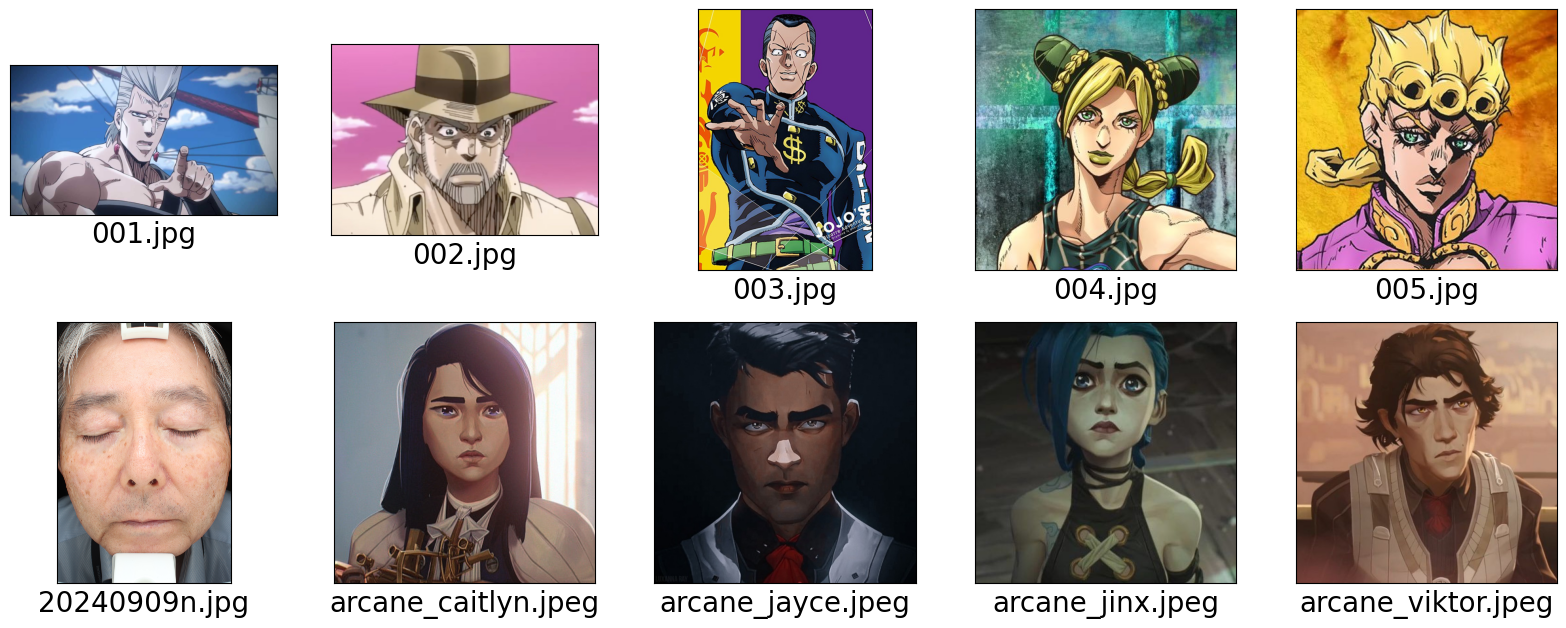

In [12]:
#@title スタイル画像表示
display_pic('style_images')

In [17]:
#@title スタイル画像のalignと潜在変数の取得
names = ['20240909n.jpg'] #@param {type:"raw"}

targets = []
latents = []

for name in names:
    style_path = os.path.join('style_images', name)
    assert os.path.exists(style_path), f"{style_path} does not exist!"

    name = strip_path_extension(name)

    # crop and align the face
    style_aligned_path = os.path.join('style_images_aligned', f'{name}.png')
    if not os.path.exists(style_aligned_path):
        style_aligned = align_face(style_path)
        style_aligned.save(style_aligned_path)
    else:
        style_aligned = Image.open(style_aligned_path).convert('RGB')

    # GAN invert
    style_code_path = os.path.join('inversion_codes', f'{name}.pt')
    if not os.path.exists(style_code_path):
        latent = e4e_projection(style_aligned, style_code_path, device)
    else:
        latent = torch.load(style_code_path)['latent']

    targets.append(transform(style_aligned).to(device))
    latents.append(latent.to(device))

targets = torch.stack(targets, 0)
latents = torch.stack(latents, 0)

#target_im = utils.make_grid(targets, normalize=True, range=(-1, 1))
target_im = utils.make_grid(targets, normalize=True, value_range=(-1, 1)) # Replace 'range' with 'value_range'
display_image(target_im, title='Style References')

/content/JoJoGAN/JoJoGAN/e4e_projection.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(model_path, map_location='cpu')


Loading e4e over the pSp framework from checkpoint: models/e4e_ffhq_encode.pt


/content/JoJoGAN/JoJoGAN/e4e/models/psp.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(self.opts.checkpoint_path, map_location='cpu')


TypeError: make_grid() got an unexpected keyword argument 'range'

In [14]:
#In util.py file, line 174
- img = img.resize(rsize, Image.ANTIALIAS)
+ img = img.resize(rsize, Image.Resampling.LANCZOS) # Replace ANTIALIAS with Resampling.LANCZOS

SyntaxError: cannot assign to expression here. Maybe you meant '==' instead of '='? (<ipython-input-14-136e88d04e28>, line 2)

In [ ]:
#@title ファインチューニング
alpha =  1.0 #@param {type:"slider", min:0, max:1, step:0.1}
alpha = 1-alpha
preserve_color = True #@param{type:"boolean"}
num_iter = 200 #@param {type:"number"}
#log_interval = 50 #@param {type:"number"}

lpips_fn = lpips.LPIPS(net='vgg').to(device)

# reset generator
del generator
generator = deepcopy(original_generator)
g_optim = optim.Adam(generator.parameters(), lr=2e-3, betas=(0, 0.99))

# Which layers to swap for generating a family of plausible real images -> fake image
if preserve_color:
    id_swap = [7,9,11,15,16,17]
else:
    id_swap = list(range(7, generator.n_latent))

for idx in tqdm(range(num_iter)):
    if preserve_color:
        random_alpha = 0
    else:
        random_alpha = np.random.uniform(alpha, 1)
    mean_w = generator.get_latent(torch.randn([latents.size(0), latent_dim]).to(device)).unsqueeze(1).repeat(1, generator.n_latent, 1)
    in_latent = latents.clone()
    in_latent[:, id_swap] = alpha*latents[:, id_swap] + (1-alpha)*mean_w[:, id_swap]

    img = generator(in_latent, input_is_latent=True)
    loss = lpips_fn(F.interpolate(img, size=(256,256), mode='area'), F.interpolate(targets, size=(256,256), mode='area')).mean()

    g_optim.zero_grad()
    loss.backward()
    g_optim.step()

# パラメータ保存
torch.save(generator.state_dict(), 'model.pth')

In [ ]:
#@title スタイル変換
import warnings
warnings.simplefilter('ignore')

# resultsフォルダーリセット
if os.path.isdir('results'):
    shutil.rmtree('results')
os.makedirs('results', exist_ok=True)

plt.rcParams['figure.dpi'] = 100

# display reference images
style_images = []
for name in names:
    style_path = f'style_images_aligned/{strip_path_extension(name)}.png'
    style_image = transform(Image.open(style_path))
    style_images.append(style_image)

style_images = torch.stack(style_images, 0).to(device)
display_image(utils.make_grid(style_images, normalize=True, range=(-1, 1)), title='References')


# model.pth ロード
generator.load_state_dict(torch.load('model.pth'))

def conversion(file):
    with torch.no_grad():
        generator.eval()
        my_w = torch.load('./vectors/'+os.path.splitext(file)[0]+'.pt')['latent'].reshape(1,18,512)
        original_my_sample = original_generator(my_w, input_is_latent=True)
        my_sample = generator(my_w, input_is_latent=True)

    aligned_face = Image.open('./align/'+file)
    face = transform(aligned_face).unsqueeze(0).to(device)

    file_path = os.path.splitext('./style_images_aligned/'+names[0])[0]+'.png'
    reference = transform(Image.open(file_path)).unsqueeze(0).to(device)

    my_output = torch.cat([reference, face, my_sample], 0)
    x = utils.make_grid(my_output, normalize=True, range=(-1, 1))
    display_image(utils.make_grid(x))
    img = torchvision.transforms.functional.to_pil_image(x)
    img.save('./results/'+file)

# 変換
files = sorted(os.listdir('./align'))
for file in files:
    if file=='.ipynb_checkpoints':
      continue
    conversion(file)

In [ ]:
#@title 動画の作成
# tmpフォルダーリセット
if os.path.isdir('tmp'):
    shutil.rmtree('tmp')
os.makedirs('tmp', exist_ok=True)

# output.mp4をリセット
if os.path.exists('./output.mp4'):
   os.remove('./output.mp4')

# resultsフォルダのファイルを連番画像にしてtmpフォルダへ保存
files = sorted(os.listdir('results'))
count = 0
for file in files:
    if file=='.ipynb_checkpoints':
      continue
    shutil.copy('./results/'+file, './tmp/'+str(count).zfill(6)+'.jpg')
    edit_pic('./tmp/'+str(count).zfill(6)+'.jpg')
    count +=1

# 連番画像をmp4に変換
!ffmpeg -r 1 -i tmp/%6d.jpg -vcodec libx264 -pix_fmt yuv420p -loglevel error output.mp4

# 動画の再生
from IPython.display import HTML
from base64 import b64encode

mp4 = open('./output.mp4', 'rb').read()
data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
HTML(f"""
<video width="70%" height="70%" controls>
      <source src="{data_url}" type="video/mp4">
</video>""")